# Project: Stochastic Gradient Hamiltonian Monte Carlo

In this project we are going to implement standard HMC, HMC with MH, Naive SGHMC and SGHMC with Friction.

# standard HMC

### Basic settings

Suppose we want to sample from the posterior distribution: 
$$p(\theta|D) \propto exp(-U(\theta))$$ where $D = \{x_{1\:n}\}$
which are independent and $U$ is the potential energy fucntion: 
$$U = -\sum_{x_i \in D}\log p(x|\theta)- \log p(\theta)$$
We will sample from joint distribution $$\pi(\theta, r) \propto exp(-U(\theta)-\frac{1}{2}r^TM^{-1}r)$$
where r is the auxiliary momentum variables and M is the mass matrix. They define the kinetic energy together.
Then we discard r and keep $\theta$.

The Hamiltonian function is:
$$H(\theta, r)=U(\theta)+\frac{1}{2}r^TM^{-1}r$$
The Hamiltonian dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt$$

### Implement HMC

We use a univariate $\theta$ for illustration. Suppose $U(\theta)=-2\theta^2+\theta^4$. Based on $U(\theta)$, we need to define functions $\triangledown U, H$.

# Stochastic Gradient HMC with Naive Approach

The Naive approach refers to the simple plug-in estimator of $\triangledown \tilde{U}(\theta) = -\frac{|D|}{|\tilde{D}|}\sum_{x \in \tilde{D}} \triangledown log p(x|\theta) - \triangledown log p(\theta)$ with minibatch $\tilde{D}$. $\triangledown \tilde{U}(\theta)$ is computationally easier, but then the resulting joint distribution $\pi(\theta, r)$ is not invariant.

The Hamiltonian Dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt + N(0,2B(\theta)) dt$$
where $B(\theta) = \frac{1}{2}\epsilon V(\theta)$

# need to find covariance of the stochastic gradient noise

Since $\epsilon$ is small, it does not really matter that V is. Thus we take V as identity.

### Implement Naive SGHMC

# SGHMC with Friction

Add friction term to momentum update:
$$
d\theta = M^{-1}r dt\\
dr = - \triangledown U(\theta)dt - BM^{-1}rdt+N(0,2Bdt)
$$

# new proposal for SGHMC with friction

In [1]:
import scipy.stats as sta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def SGHMC_friction2(theta0, X, grad_logden_data, grad_logden_prior, eps, i, B, C, batch_size,burnin,seed=1, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    i: number of iterations
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    n = theta0.shape[0]
    rt = np.zeros((i+1,n))
    thetat = np.zeros((i+1,n))
    thetat[0,:] = theta0
    batch = minib(X,batch_size)
    m = len(batch)

    if(M is None):
        M = np.eye(n)
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(n), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            sumg = 0
            for x in batch[j]:
                sumg += grad_logden_data(x,thetai)-grad_logden_prior(thetai)
            gU = - X.shape[0]/batch[j].shape[0]* sumg
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri + np.random.multivariate_normal(np.zeros(n), np.array(2*eps*(C-B)).reshape(n,n)).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)
    
    return thetat[burnin+1:,],rt[burnin+1:,:]
        

In [3]:
def SGHMC_friction3(theta0, X, grad_logden_data, grad_logden_prior, eps, i, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    i: number of iterations
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    n = theta0.shape[0]
    rt = np.zeros((i+1,n))
    thetat = np.zeros((i+1,n))
    thetat[0,:] = theta0
    batch = minib(X,batch_size)
    m = len(batch)

    if(M is None):
        M = np.eye(n)
        
    Msqrt = np.linalg.cholesky(2*eps*(C-B))
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(n), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            sumg = 0
            for x in batch[j]:
                sumg += grad_logden_data(x,thetai)-grad_logden_prior(thetai)
            gU = - X.shape[0]/batch[j].shape[0]* sumg
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri + (Msqrt@np.random.normal(size=n)).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)
    
    return thetat[burnin+1:,],rt[burnin+1:,:]

In [4]:
def grad_logden_data(x,theta):
    return -(-4*theta+4*theta**3)/50

In [5]:
def grad_prior(theta):
    return 0

In [6]:
import random

In [32]:
%%time
random.seed(100)
theta1,r1 = SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)),grad_logden_data = grad_logden_data,grad_logden_prior = grad_prior,
                eps=0.1,i=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 3.94 s, sys: 0 ns, total: 3.94 s
Wall time: 3.94 s


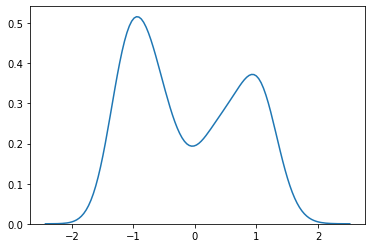

In [33]:
sns.kdeplot(theta1.reshape(-1,))

In [9]:
%%time
random.seed(100)
theta,r = SGHMC_friction3(theta0 = np.array([0]),X = np.zeros((50,1)),grad_logden_data = grad_logden_data,grad_logden_prior = grad_prior,
                eps=0.1,i=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 2.16 s, sys: 0 ns, total: 2.16 s
Wall time: 2.16 s


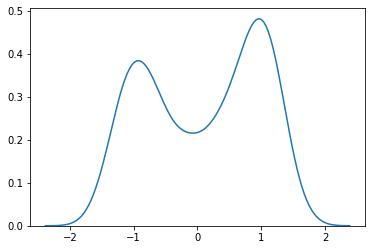

In [10]:
sns.kdeplot(theta.reshape(-1,))

In [36]:
mu = np.array([-5, 5]).reshape(2,1) # true value for mu
n = 200 # number of observations
y = np.r_[np.random.normal(mu[0], 1, n),np.random.normal(mu[1], 1, n)]

In [37]:
def mn_glpdf(y,mu):
    exp1=np.exp(-0.5*(y-mu[0])**2)
    exp2=np.exp(-0.5*(y-mu[1])**2)
    
    v = np.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]
    return np.sum(v/(exp1+exp2),axis=0)

def mn_glpr(mu):
    return -(np.sum(mu)/100)

In [38]:
theta_mn,r_mn = SGHMC_friction2(theta0=np.array([1,1]), X = y[:,None], grad_logden_data=mn_glpdf, grad_logden_prior=mn_glpr, eps=0.01, i=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

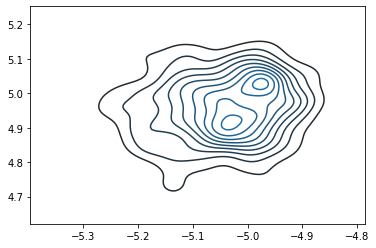

In [39]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

## take simulated data from normal distribution as example

Simulate 1000 samples from N($\mu=10$,100). We want to sample $\mu$ from the posterior $p(\mu|D)$.

In [17]:
x = np.random.normal(10,10,1000)
x

array([ 17.80940264, -12.90820253,   7.28730158,  11.06798918,
        11.60151888,  11.52779961,  13.94589599,   6.89335457,
         3.16399043,   8.40223896,  13.50102312,  -1.40375701,
        19.15975341,   4.18365302,  17.96333108,  24.49682133,
        22.0669001 ,  28.21241096,  13.91144207,  12.41888075,
        27.3721917 ,  12.00762573,  22.81031273,  -1.66883626,
        14.16268348,  10.31081083,   3.37091621,   1.85686351,
         9.12526968,   1.23114633,   8.73409384,  12.12821401,
        21.82392889,  -1.67923164,   7.77180986,  28.60366585,
         3.398824  ,  11.904201  ,  12.57085559,  -1.29833357,
         0.76868049,   6.0881222 ,  20.58094711,  13.86919508,
        18.89686745,   8.20342771,  11.93477613,  27.14852621,
         2.67665932,  17.02110929,  21.18588254,   3.9019094 ,
        19.22471588,  19.99143714,   8.89151477,  10.780995  ,
        23.25832844,  19.99770292,  24.17510603,  -1.59341681,
        -2.83259822,  14.63235251, -12.78731209,  16.17

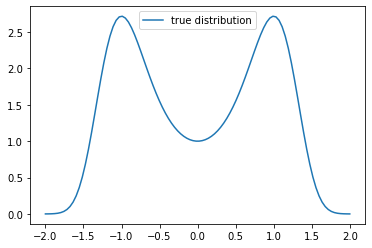

In [30]:
theta = np.linspace(-2,2,100)
p = np.exp(2*theta**2-theta**4)
fig, ax = plt.subplots()
ax.plot(theta,p,label = "true distribution")
ax.legend(loc= "upper center")

array([[1., 0.],
       [0., 1.]])